In [13]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from imblearn.over_sampling import BorderlineSMOTE

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import learning_curve

In [15]:
dataset_path = 'magic_dataset/magic04.csv'

columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'label']
df=pd.read_csv(dataset_path, names=columns, header=None)

In [16]:
def prepare_data(df, outlier, param_outlier, scale):
    """
    Thif function is used to prepare the dataset
    
    @param 
             df: pandas dataframe containing the training dataset
    @param
        outlier: Boolen for removing or not the data
    @param
        param_outlier: n_neighbors for the outlier
    @param
        scale: to scale the training dataset or not 
    
    @return
        X_train, X_test, y_train, y_test
        skf: the stratified kfold
    """
    
    #Do you want to use outlier removal?
    if outlier:
        local_outlier = LocalOutlierFactor(param_outlier)
        mask = local_outlier.fit_predict(df.iloc[:,:-1])
        mask = mask==1
        df = df[mask].copy()

    df = df.drop('fConc1', axis=1)

    X = df.drop(['label'], axis=1).copy()
    y = df.label.copy()
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, shuffle=True, stratify=y) # stratify version

    #Do you want to use the scaler?
    if scale:
        scaler = RobustScaler()
        fitted_scaler = scaler.fit(X=X_train)
        X_train = fitted_scaler.transform(X_train)
        X_test = fitted_scaler.transform(X_test)

    skf = StratifiedKFold(n_splits=11, shuffle=True, random_state=42)
    skf.get_n_splits(X_train, y_train)

    return X_train, X_test, y_train, y_test, skf

In [17]:
def plot_roc_learningcurve(pipeline, df, outlier, param_outlier, scale, model_name) :
    X_train, X_test, y_train, y_test, skf = prepare_data(df, outlier, param_outlier, scale)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
    
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=skf, return_times=False)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     # Plot learning curve
    fig, axe = plt.subplots(figsize=(10, 7))
    axe.grid()
    axe.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axe.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axe.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axe.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axe.legend(loc="best")
    axe.set_xlabel("Training examples")
    axe.set_ylabel("Score")
    plt.title('Learning curve',fontsize='x-large')
    plt.suptitle(model_name, fontsize='xx-large', weight='bold')
    plt.show()
    #plt.plot(fpr,tpr)
    #plt.show()
    return fpr,tpr,auc

# RandomForest con BorderlineSMOTE

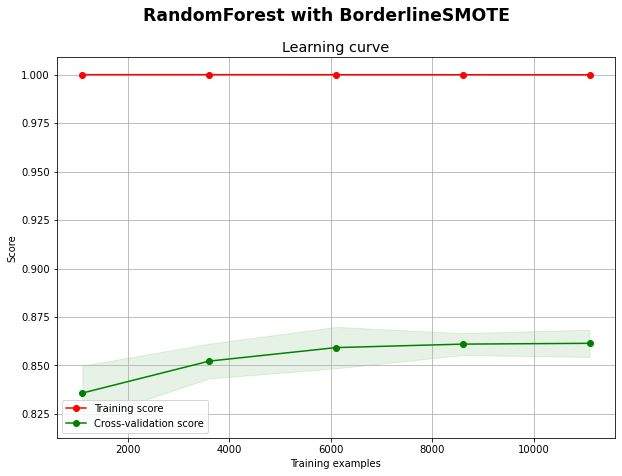

In [18]:
#0.16
outlier = True
param_outlier = 20
scale = True

n_estimators = 200
criterion ='entropy'
max_depth = 20

model = RandomForestClassifier(n_jobs=-1, random_state=10,
                                n_estimators=n_estimators,
                                criterion=criterion,
                                max_depth=max_depth)
                                
pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE( sampling_strategy='all',k_neighbors=8)],
                                ['classifier', model]])


fpr_RF_BS,tpr_RF_BS,auc_RF_BS =plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale, "RandomForest with BorderlineSMOTE")


# RandomForest with SMOTE

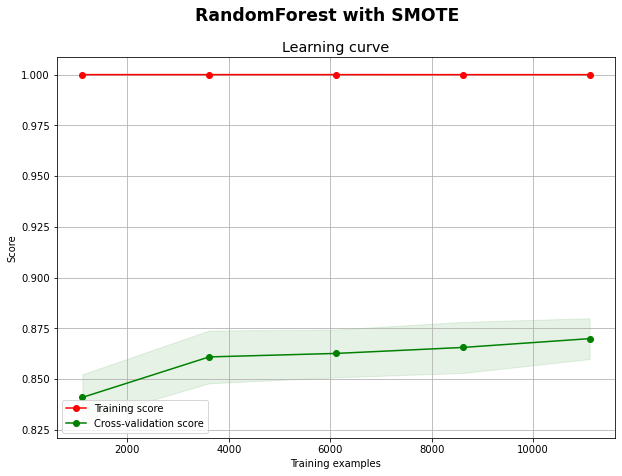

In [19]:
#0.17
outlier = True
param_outlier = 15
scale = False

n_estimators = 101
criterion ='gini'
max_depth = 55

model = RandomForestClassifier(n_jobs=-1, random_state=10,
                                n_estimators=n_estimators,
                                criterion=criterion,
                                max_depth=max_depth)
                                   
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                ['classifier', model]])

fpr_RF_S,tpr_RF_S,auc_RF_S =plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"RandomForest with SMOTE")


# Logistic Regression with BorderLine SMOTE


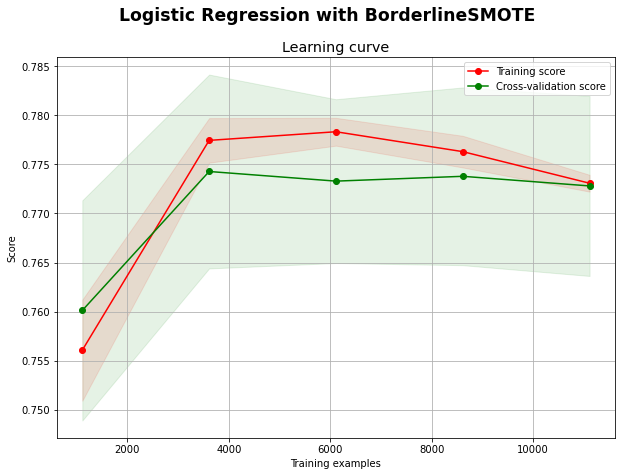

In [20]:
#0.23
outlier = True
param_outlier = 10
scale = True

model = LogisticRegression( random_state=10, penalty='l1', 
                            C=0.02, solver='liblinear')
                                  
pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE( sampling_strategy='minority', k_neighbors=10)],
                                ['classifier', model]])

fpr_LR_BS,tpr_LR_BS,auc_LR_BS =plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"Logistic Regression with BorderlineSMOTE")


# Logistic Regression with SMOTE


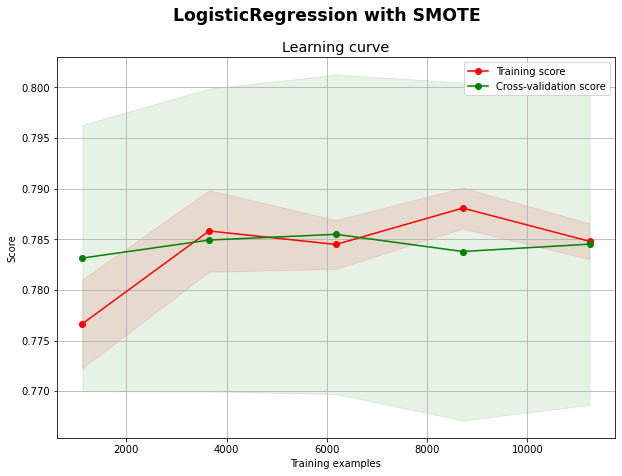

In [21]:
#0.27
outlier = False
scale = True

model = LogisticRegression(random_state=10,
                           solver='liblinear',
                           penalty='l1', C = 0.02 )
                                
 
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                ['classifier', model]])


fpr_LR_S,tpr_LR_S,auc_LR_S=plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"LogisticRegression with SMOTE")

# KNN with BorderLine

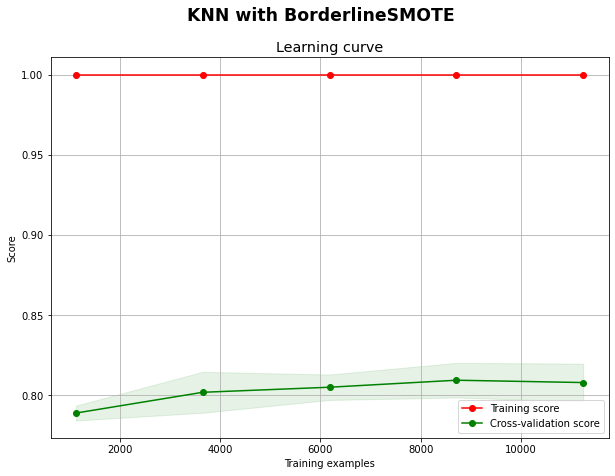

In [22]:
#0.18
outlier = False
scale = True


model = KNeighborsClassifier(   n_jobs=-1,
                                weights='distance',
                                n_neighbors=30)
                                
pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE( sampling_strategy='all',k_neighbors=10)],
                                ['classifier', model]])


fpr_KN_BS,tpr_KN_BS,auc_KN_BS=plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"KNN with BorderlineSMOTE")


# KNN with SMOTE

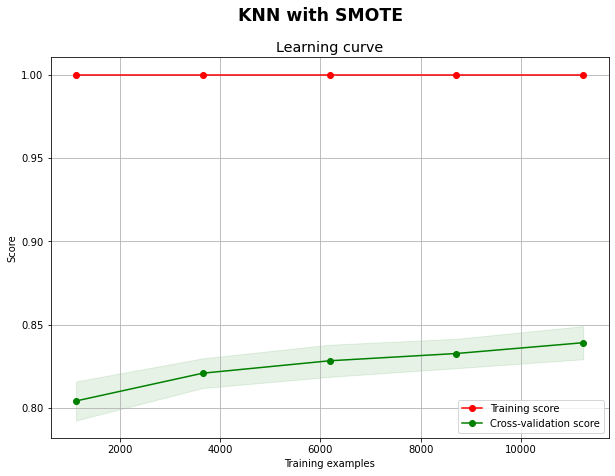

In [23]:
#0.25
outlier = False
scale = True


model = KNeighborsClassifier(   n_jobs=-1,
                                weights='distance',
                                n_neighbors=38)
                                
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                ['classifier', model]])


fpr_KN_S,tpr_KN_S,auc_KN_S=plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"KNN with SMOTE")


# SVM Gaussian kernel BorderlineSMOTE

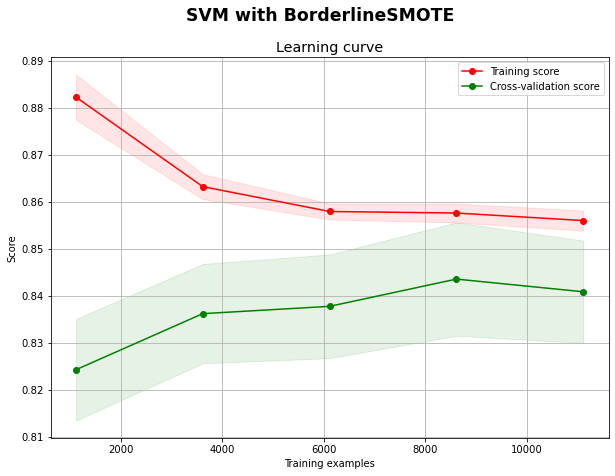

In [24]:
#0.14
outlier = True
param_outlier = 10
scale = True

model = SVC(    random_state=10,
                gamma='auto',
                C=7, probability=True)
                                
pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE( sampling_strategy='minority',k_neighbors=5)],
                                ['classifier', model]])


fpr_SVM_BS,tpr_SVM_BS,auc_SVM_BS=plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale, "SVM with BorderlineSMOTE")


# SVM Gaussian Kernel SMOTE


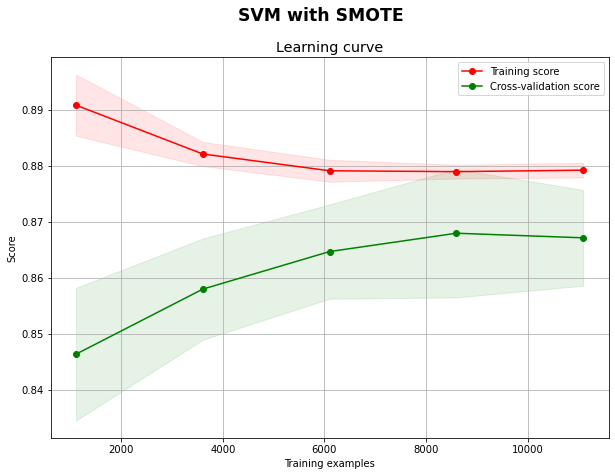

In [25]:
#0.19
outlier = True
param_outlier = 20
scale = True

model = SVC(    random_state=10,
                gamma='auto',
                C=7,
                probability=True)
                                
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                ['classifier', model]])


fpr_SVM_S,tpr_SVM_S,auc_SVM_S=plot_roc_learningcurve(pipeline, df ,outlier,param_outlier,scale,"SVM with SMOTE")


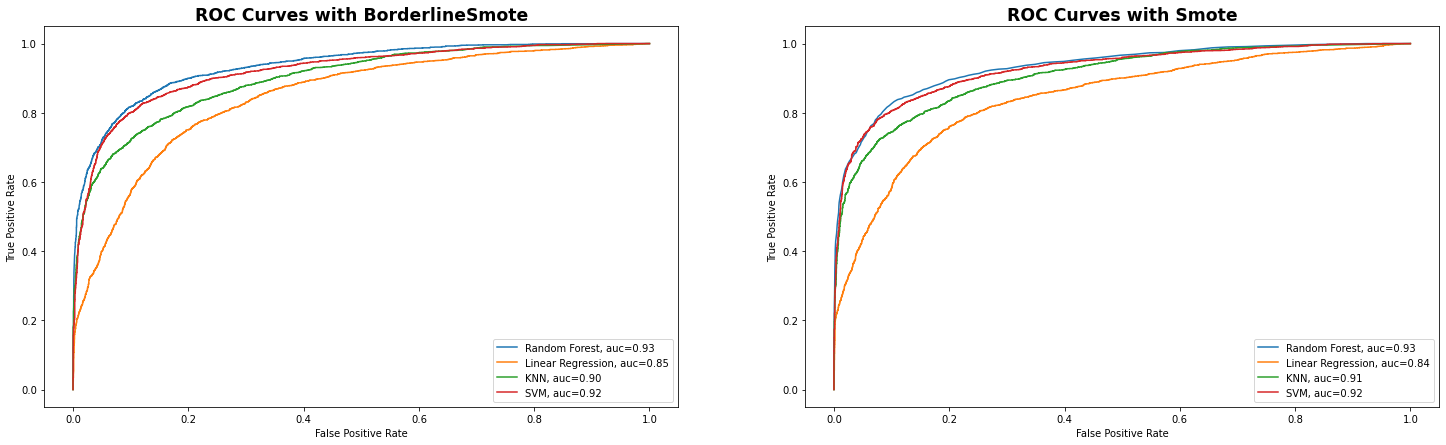

In [26]:
fig, ax = plt.subplots(1,2,figsize=(25,7))

ax[0].plot(fpr_RF_BS,tpr_RF_BS,label="Random Forest, auc="+str(format(auc_RF_BS,".2f")))
ax[0].plot(fpr_LR_BS,tpr_LR_BS,label="Linear Regression, auc="+str(format (auc_LR_BS,".2f")))
ax[0].plot(fpr_KN_BS,tpr_KN_BS,label="KNN, auc="+str(format(auc_KN_BS,".2f")))
ax[0].plot(fpr_SVM_BS,tpr_SVM_BS,label="SVM, auc="+str(format(auc_SVM_BS,".2f")))
ax[0].legend()
ax[0].set_title("ROC Curves with BorderlineSmote", fontsize='xx-large',weight='bold')
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xlabel("False Positive Rate")

ax[1].plot(fpr_RF_S,tpr_RF_S,label="Random Forest, auc="+str(format(auc_RF_S,".2f")))
ax[1].plot(fpr_LR_S,tpr_LR_S,label="Linear Regression, auc="+str(format(auc_LR_S,".2f")))
ax[1].plot(fpr_KN_S,tpr_KN_S,label="KNN, auc="+str(format(auc_KN_S,".2f")))
ax[1].plot(fpr_SVM_S,tpr_SVM_S,label="SVM, auc="+str(format(auc_SVM_S,".2f")))
ax[1].legend()
ax[1].set_title("ROC Curves with Smote", fontsize='xx-large',weight='bold')
ax[1].set_ylabel("True Positive Rate")
ax[1].set_xlabel("False Positive Rate")

plt.show()